In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import datetime as dt
import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


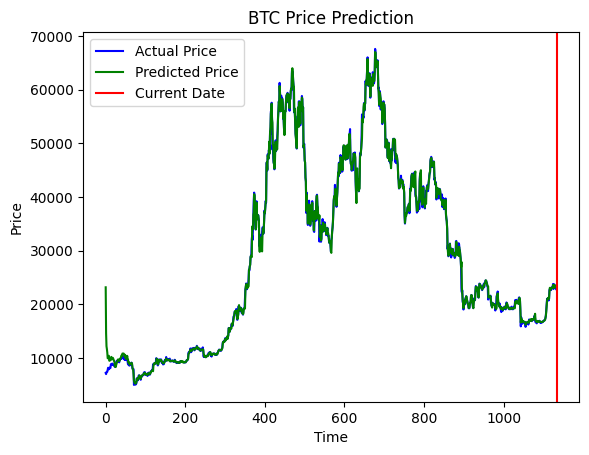

In [87]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', start=start, end=end)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60
now = dt.datetime.now() - start
now = now.days


x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#Create XGBoost Model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

model.fit(x_train, y_train)


# Testing Model

test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()
test_data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', start= test_start, end= test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])
    
x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices.reshape(-1, 1))


plt.plot(actual_prices, color='blue', label='Actual Price')
plt.plot(prediction_prices, color='green', label='Predicted Price')
plt.axvline(now , color='red', label = 'Current Date')
plt.title(f'{crypto_currency} Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [88]:
percent_error = abs((actual_prices[(now - 9):] - prediction_prices[(now - 9):]) / actual_prices[(now - 9):]) * 100
avg_percent_error = percent_error.mean()
avg_percent_error = round(avg_percent_error, 2)

print(f"Average percent error: {avg_percent_error}%")
# print(prediction_prices[now-6:])
# print(actual_prices[now-6:])

Average percent error: 1.5%


In [89]:
# Predict the Next Day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (1, prediction_days))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction.reshape(-1, 1))



# print(prediction)
high_prediction = prediction * (1 + (avg_percent_error/100))
low_prediction = prediction * (1 - (avg_percent_error/100))


# print(actual_prices[now -1])
print("high: $" + str(high_prediction[0][0]) + ", low: $" + str(low_prediction[0][0]) + ", rough estimate prediction: $" + str(prediction[0][0]))
print("Current Price: $" + str(actual_prices[-1]))

high: $23504.643, low: $22809.924, rough estimate prediction: $23157.283
Current Price: $22898.177734375
